# Creating ImageNet-Captions

This notebook creates embeddings for the ImageNet-Captions dataset for various embedding model. This dataset is created using a subset of ImageNet images that are from the 50 most frequent classes from the original validation set, with captions retrieved from the original Flickr posts. 

In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Retrieve Subset of the Original Training Set

Please see the original [ImageNet-Captions](https://github.com/mlfoundations/imagenet-captions) for background on this dataset. This dataset is specified by a a subset of ImageNet images that whose original source was Flickr; these images are paired with their original captions. We use a subset of this dataset with approximately 200k images. The image filename and caption for each training example are listed in the `data/imagenet_captions_train_c250.csv` file. We assume that the `imagenet_images_flickr` folder exists within the `DATA_PATH` specified below.

In [15]:
NUM_CLASSES = 250
DATA_PATH = f'/mnt/ssd/ronak/datasets/imagenet_captions_{NUM_CLASSES}k'
DEVICE = 'cuda:0'

In [17]:
train_df = pd.read_csv(f"../data/imagenet_captions_train_c{NUM_CLASSES}.csv", header=0, sep="\t")
val_df = pd.read_csv(f"../data/imagenet_captions_val_c{NUM_CLASSES}.csv", header=0, sep="\t")
class_df = pd.read_csv("../data/map_clsloc.txt", sep=" ", header=None)

class_df.columns = ["directory", "class_idx", "class_name"]
train_df

,title,filepath
0,120-2060_IMG,imagenet_images_flickr/n01871265/229706807.jpg
1,127-2701_IMG,imagenet_images_flickr/n01871265/229749569.jpg
2,Tusker,imagenet_images_flickr/n01871265/48085040.jpg
3,Old Tusker,imagenet_images_flickr/n01871265/2039863126.jpg
4,IMG_0031,imagenet_images_flickr/n01871265/2105099569.jpg
...,...,...
174589,Royal Albatross (Northern),imagenet_images_flickr/n02058221/2362697397.jpg
174590,albatross,imagenet_images_flickr/n02058221/3334244815.jpg
174591,mollymawk 3,imagenet_images_flickr/n02058221/79045502.jpg
174592,Laysan albatross w/ chick,imagenet_images_flickr/n02058221/2517173423.jpg


In [18]:
class_df = class_df.set_index("directory")
class_df

,class_idx,class_name
directory,,
n02119789,1,kit_fox
n02100735,2,English_setter
n02110185,3,Siberian_husky
n02096294,4,Australian_terrier
n02102040,5,English_springer
...,...,...
n03063599,996,coffee_mug
n04116512,997,rubber_eraser
n04325704,998,stole


We confirm that the class labels match the folders correctly.

folder n01871265 corresponds to class tusker.


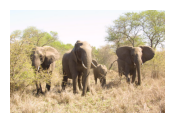

In [20]:
files = list(train_df['filepath'])
files = [os.path.join(DATA_PATH, f) for f in files]
folder = os.path.split(files[0])[0].split("/")[-1]
class_name = class_df.loc[folder]['class_name']

print(f"folder {folder} corresponds to class {class_name}.")


img = mpimg.imread(files[0])

fig, ax = plt.subplots(figsize=(2, 2))
ax.axis("off")
ax.imshow(img)
plt.show()

We use three different embedding models: CLIP, BERT, and GPT-2.

## Create Image and Text Embeddings using CLIP ViT-B/32

We use [ViT-B/32](https://github.com/ronakdm/open_clip_dev/blob/main/docs/PRETRAINED.md) model trained on LAION-2B, which reaches an ImageNet top-1 zero-shot accuracy of 65.62%. Please ensure that [OpenCLIP](https://github.com/mlfoundations/open_clip) is installed.

In [21]:
import open_clip
from training.data import get_data, CsvDataset
from training.params import parse_args
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler

MODEL_NAME = "vit_b32_laion2b"

In [22]:
model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
model.to(DEVICE)
tokenizer = open_clip.get_tokenizer('ViT-B-32')

print("Log scale:", model.logit_scale)
print("Scale:", model.logit_scale.exp())

RuntimeError: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW

In [ ]:
params = [
    "--train-data", f"{DATA_PATH}/imagenet_captions_train_c{NUM_CLASSES}.csv",
    "--val-data", f"{DATA_PATH}/imagenet_captions_val_c{NUM_CLASSES}.csv",
    "--dataset-type", "csv",
    "--csv-img-key", "filepath",
    "--csv-caption-key", "title"
]
args = parse_args(params)
args.distributed = False